In [1]:
# Binary Classifier implementation (model architecture, training, testing, etc.) derived from
#     https://towardsdatascience.com/pytorch-tabular-binary-classification-a0368da5bb89

In [2]:
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tree import Tree
import numpy as np
import pickle
import random
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from stanfordcorenlp import StanfordCoreNLP
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [3]:
MAX_PHRASE_LEN = 6

SHOULD_EXTRACT_NOUN_PHRASES = False
SHOULD_GENERATE_UNDERSCORED_CORPUS = False
SHOULD_TRAIN_WORD2VEC_MODEL = False

EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001

In [4]:
with open('data/arxiv_abstracts_10000.txt', 'r') as f:
    arxiv_abstracts = f.read().split('\n')[:-1]
    arxiv_abstracts_raw = '\n'.join(arxiv_abstracts)
    f.close()
print(f'Loaded {len(arxiv_abstracts)} arxiv abstracts.')

Loaded 10000 arxiv abstracts.


In [5]:
negative_samples = pickle.load(open('data/negative_samples.pkl', 'rb'))
print(f'Loaded {len(negative_samples)} negative samples.')

Loaded 1900 negative samples.


In [6]:
positive_samples = pickle.load(open('data/positive_samples.pkl', 'rb'))
print(f'Loaded {len(positive_samples)} positive samples.')

Loaded 1900 positive samples.


In [7]:
def extract_phrase(tree_str, label):
    phrases = []
    trees = Tree.fromstring(tree_str)
    for tree in trees:
        for subtree in tree.subtrees():
            if subtree.label() == label:
                t = subtree
                t = ' '.join(t.leaves())
                phrases.append(t)
    return phrases

In [8]:
if SHOULD_EXTRACT_NOUN_PHRASES:
    nlp = StanfordCoreNLP('data/stanford-corenlp-4.1.0')
    noun_phrases = []
    for i, abstract in enumerate(arxiv_abstracts):
        if (i + 1) % 10 == 0:
            print(f'Extracting noun phrases from abstract {i + 1} of {len(arxiv_abstracts)}')
            pickle.dump(noun_phrases, open('data/noun_phrases.pkl', 'wb'))
        try:
            tree_str = nlp.parse(abstract)
            noun_phrases.extend(extract_phrase(tree_str, 'NP'))
        except Exception:
            pass
    noun_phrases = [np for np in list(set(noun_phrases)) if len(np.split()) <= MAX_PHRASE_LEN]
    pickle.dump(noun_phrases, open('data/noun_phrases.pkl', 'wb'))
noun_phrases = pickle.load(open('data/noun_phrases.pkl', 'rb'))

In [9]:
def find_phrase_in_corpus(corpus, phrase):
    s_idx = corpus.find(phrase)
    e_idx = s_idx + len(phrase)
    if s_idx != -1 and \
       (s_idx == 0 or corpus[s_idx - 1] in (string.punctuation + ' ')) and \
       (e_idx == len(corpus) or corpus[e_idx] in (string.punctuation + ' ')):
        return (s_idx, e_idx)
    return (-1, -1)

In [10]:
if SHOULD_GENERATE_UNDERSCORED_CORPUS:
    corpus = arxiv_abstracts_raw[:]

In [11]:
if SHOULD_GENERATE_UNDERSCORED_CORPUS:
    for i, positive_sample in enumerate(positive_samples):
        if (i + 1) % 100 == 0:
            print(f'Replacing positive_sample {i + 1} of {len(positive_samples)}')
        found_indices = set()
        while find_phrase_in_corpus(corpus, positive_sample) != (-1, -1) and find_phrase_in_corpus(corpus, positive_sample)[0] not in found_indices:
            s_idx, e_idx = find_phrase_in_corpus(corpus, positive_sample)
            found_indices.add(s_idx)
            corpus = corpus[:s_idx] + positive_sample.replace(' ', '_') + corpus[e_idx:]

In [12]:
if SHOULD_GENERATE_UNDERSCORED_CORPUS:
    for i, negative_sample in enumerate(negative_samples):
        if (i + 1) % 100 == 0:
            print(f'Replacing negative_sample {i + 1} of {len(negative_samples)}')
        found_indices = set()
        while find_phrase_in_corpus(corpus, negative_sample) != (-1, -1) and find_phrase_in_corpus(corpus, negative_sample)[0] not in found_indices:
            s_idx, e_idx = find_phrase_in_corpus(corpus, negative_sample)
            found_indices.add(s_idx)
            corpus = corpus[:s_idx] + negative_sample.replace(' ', '_') + corpus[e_idx:]

In [13]:
if SHOULD_GENERATE_UNDERSCORED_CORPUS:
    for i, noun_phrase in enumerate(noun_phrases):
        if (i + 1) % 100 == 0:
            print(f'Replacing noun_phrase {i + 1} of {len(noun_phrases)}')
        found_indices = set()
        while find_phrase_in_corpus(corpus, noun_phrase) != (-1, -1) and find_phrase_in_corpus(corpus, noun_phrase)[0] not in found_indices:
            s_idx, e_idx = find_phrase_in_corpus(corpus, noun_phrase)
            found_indices.add(s_idx)
            corpus = corpus[:s_idx] + noun_phrase.replace(' ', '_') + corpus[e_idx:]

In [14]:
if SHOULD_GENERATE_UNDERSCORED_CORPUS:
    pickle.dump(corpus, open('data/underscored_corpus.pkl', 'wb'))

In [15]:
underscored_corpus = pickle.load(open('data/underscored_corpus.pkl', 'rb'))

In [16]:
if SHOULD_TRAIN_WORD2VEC_MODEL:
    underscored_corpus_data = []
    for i in sent_tokenize(underscored_corpus):
        temp = []
        for j in word_tokenize(i):
            temp.append(j.lower())
        underscored_corpus_data.append(temp)

In [17]:
if SHOULD_TRAIN_WORD2VEC_MODEL:
    word2vec_model = Word2Vec(underscored_corpus_data, min_count=1, window=5, size=100)
    word2vec_model.save('data/word2vec_model')

In [18]:
word2vec_model = Word2Vec.load('data/word2vec_model')

In [19]:
tokens = [token for token in list(word2vec_model.wv.vocab.keys())]
embeddings = {token: word2vec_model.wv[token] for token in tokens}

In [20]:
positive_samples = [ps for ps in positive_samples if ps.replace(' ', '_') in embeddings]
negative_samples = [ns for ns in negative_samples if ns.replace(' ', '_') in embeddings]
noun_phrases = [np for np in noun_phrases if np.replace(' ', '_') in embeddings]

In [21]:
X = []
y = []
for phrase in positive_samples:
    X.append(embeddings[phrase.replace(' ', '_')])
    y.append(1)
for phrase in negative_samples:
    X.append(embeddings[phrase.replace(' ', '_')])
    y.append(0)

In [22]:
c = list(zip(X, y))
random.shuffle(c)
X, y = zip(*c)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [24]:
class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()

        self.layer_1 = nn.Linear(100, 128) 
        self.layer_2 = nn.Linear(128, 128)
        self.layer_out = nn.Linear(128, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(128)
        self.batchnorm2 = nn.BatchNorm1d(128)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = BinaryClassifier()
model.to(device)

BinaryClassifier(
  (layer_1): Linear(in_features=100, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=128, bias=True)
  (layer_out): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [26]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [27]:
class TrainDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

train_data = TrainDataset(torch.FloatTensor(np.array(X_train, dtype=np.float64)), 
                          torch.FloatTensor(y_train))

In [28]:
class TestDataset(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = TestDataset(torch.FloatTensor(np.array(X_test, dtype=np.float64)))

In [29]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [30]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [31]:
epoch_losses = []
for e in range(1, EPOCHS + 1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch)

        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    epoch_losses.append(epoch_loss / len(train_loader)) 

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 0.60131 | Acc: 68.636
Epoch 002: | Loss: 0.54271 | Acc: 72.159
Epoch 003: | Loss: 0.52132 | Acc: 73.705
Epoch 004: | Loss: 0.51443 | Acc: 73.886
Epoch 005: | Loss: 0.49738 | Acc: 74.818
Epoch 006: | Loss: 0.48906 | Acc: 75.409
Epoch 007: | Loss: 0.49121 | Acc: 75.205
Epoch 008: | Loss: 0.48059 | Acc: 76.159
Epoch 009: | Loss: 0.48048 | Acc: 75.682
Epoch 010: | Loss: 0.47491 | Acc: 76.068
Epoch 011: | Loss: 0.47278 | Acc: 76.523
Epoch 012: | Loss: 0.46859 | Acc: 76.386
Epoch 013: | Loss: 0.46699 | Acc: 76.864
Epoch 014: | Loss: 0.45135 | Acc: 77.864
Epoch 015: | Loss: 0.46314 | Acc: 77.023
Epoch 016: | Loss: 0.45499 | Acc: 77.773
Epoch 017: | Loss: 0.46398 | Acc: 76.500
Epoch 018: | Loss: 0.45681 | Acc: 75.841
Epoch 019: | Loss: 0.43753 | Acc: 78.114
Epoch 020: | Loss: 0.44894 | Acc: 77.659
Epoch 021: | Loss: 0.44852 | Acc: 77.727
Epoch 022: | Loss: 0.44890 | Acc: 77.091
Epoch 023: | Loss: 0.44337 | Acc: 77.841
Epoch 024: | Loss: 0.44194 | Acc: 77.614
Epoch 025: | Los

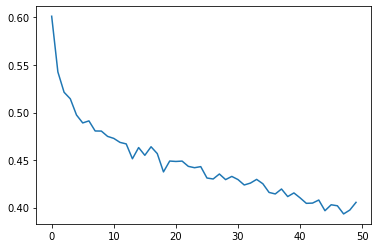

In [32]:
plt.plot(epoch_losses)

In [33]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [34]:
print(confusion_matrix(y_test, y_pred_list))
print(classification_report(y_test, y_pred_list))

[[309  32]
 [242 114]]
              precision    recall  f1-score   support

           0       0.56      0.91      0.69       341
           1       0.78      0.32      0.45       356

    accuracy                           0.61       697
   macro avg       0.67      0.61      0.57       697
weighted avg       0.67      0.61      0.57       697



In [35]:
test_samples = random.sample(noun_phrases, 10000)
X_samples = []
for sample in test_samples:
    X_samples.append(embeddings[sample.replace(' ', '_')])
sample_data = TestDataset(torch.FloatTensor(np.array(X_samples, dtype=np.float64)))
sample_loader = DataLoader(dataset=sample_data, batch_size=1)

extracted = []
not_extracted = []
model.eval()
with torch.no_grad():
    for i, X_batch in enumerate(sample_loader):
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        if y_pred_tag.cpu().numpy()[0][0] == 1:
            extracted.append(test_samples[i])
        else:
            not_extracted.append(test_samples[i])

In [36]:
extracted

['improvements',
 'an online learning problem',
 'text recognition',
 'missing elements',
 'information extraction',
 'resource',
 'capacity',
 'transition',
 'bio informatics blind source separation',
 'pathological from normal eeg recordings in the temple university hospital eeg abnormal corpus',
 'approximation',
 'surveillance videos',
 'computer networks',
 'optical flow',
 'communication',
 'media',
 'rotation',
 'visual classification problems',
 'the current state of the art',
 'object classification',
 'animals',
 'loop',
 'phones',
 'a central role',
 'a crucial task',
 'grouping',
 'drugs',
 'other settings',
 'navigation',
 'relation extraction',
 'aogtracker',
 'records',
 'the reasoning',
 'one user',
 'the images',
 'bioinformatics',
 'translation systems',
 'sarcasm detection',
 'multilayer neural networks',
 'news',
 'only basic bit logic',
 'negative samples',
 'cluttered environments',
 'optimality',
 'interpretability',
 'cue',
 'research',
 'quality',
 'description

In [37]:
not_extracted

['a markov chain monte carlo sampling technique that iteratively samples variables from their conditional distributions',
 'parallel corpora',
 'sequences of characters rather than words',
 'problems',
 'environments with sparse feedback',
 'parallelism and density',
 'the multilingual topic model',
 'various chemicals via food additives cleaning',
 'binary class labels',
 'efficient learning methods',
 'an approach',
 'a formally elegant approach',
 'memory neural networks called feedforward sequential memory networks fsmn which can learn long term dependency without using recurrent feedback',
 'the most important hyper parameter to tune for training deep neural networks',
 'deep neural network architectures',
 'innovation and discovery',
 'fixed nonlinear activation functions',
 'time bptt',
 'a periodic basis',
 'preference elicitation that is suitable to large configuration spaces beyond the reach of existing state of the art approaches',
 'the optimal value',
 'more',
 'the graph'